In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import glob

In [28]:
class point:

    def __init__(self, x, y, data):
        #point data
        self.x = x
        self.y = y
        self.data = data

    def __repr__(self):
        return f'{{"x": {self.x}, "y": {self.y}}}'
   
class quadtree:

    def __init__(self, x, y, l):
        #initialize quadtree object
        self.x = x
        self.y = y
        self.l = l
        self.points = []
        self.divided = False
        self.topleft = None
        self.topright = None
        self.botleft = None
        self.botright = None
        self.parent = None
        self.dualweight = []
        self.flow = []
        self.mass = 0
        self.min_cost_child = None
        self.cost_to_parent = 0
        self.augment_cost = 0
        self.augment_path_cost = 0
        self.augment_mass = 0
        self.id = None

    def __repr__(self):
        return f'{{"x": {self.x}, "y": {self.y}, "id": {self.id}}}'

    def contains(self, point):
        # checks if point falls within a cell
        xcheck = self.x - (self.l / 2) <= point.x and self.x + (self.l / 2) >= point.x
        ycheck = self.y - (self.l / 2) <= point.y and self.y + (self.l / 2) >= point.y
        return xcheck and ycheck

    def subdivide(self):
        #divide up the current cell
        x, y, l = self.x, self.y, self.l

        self.topleft = quadtree(x-l/4, y+l/4, l/2)
        self.topleft.parent = self

        self.topright = quadtree(x+l/4, y+l/4, l/2)
        self.topright.parent = self

        self.botleft = quadtree(x-l/4, y-l/4, l/2)
        self.botleft.parent = self

        self.botright = quadtree(x+l/4, y-l/4, l/2)
        self.botright.parent = self

        self.divided = True

        for point in self.points:
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)

        self.points = []

    def insert(self, point):
        #insert a point into the quadtree starting at root
        if not self.contains(point):
            return None
        elif self.divided:
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)
            return leaf
        elif len(self.points) == 0:
            self.points.append(point)
            return self
        else:
            self.subdivide()
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)
            return leaf

    def backward_insert(self, point):
        #insert a point into the quadtree bottom-up recursively starting at leaf

        leaf = self.insert(point)
        if leaf == None:
            return self.parent.backward_insert(point)
        
        return leaf

    def insert_list(qtree, points):
        #insert a list of points into the quadtree
        q = qtree
        for p in points:
            q = q.backward_insert(p)

    def killemptychildren(self):
        #get rid of any cells that do not have points inisde
        if not self.divided and len(self.points) != 0:
            return

        if not self.topleft.divided and len(self.topleft.points) == 0:
            self.topleft = None
        else:
            self.topleft.killemptychildren()
        
        if not self.topright.divided and len(self.topright.points) == 0:
            self.topright = None
        else:
            self.topright.killemptychildren()

        if not self.botleft.divided and len(self.botleft.points) == 0:
            self.botleft = None
        else:
            self.botleft.killemptychildren()

        if not self.botright.divided and len(self.botright.points) == 0:
            self.botright = None
        else:
            self.botright.killemptychildren()

    def printsub(self):
        print(self)
        if len(self.points) != 0:
            print(self.points[0].data)
        if self.divided is False and len(self.points) > 0:
            # print((self.x, self.y, self.l))
            # print(self.points)
            pass
        else:
            if self.topleft is not None:
                self.topleft.printsub()
            if self.topright is not None:
                self.topright.printsub()
            if self.botleft is not None:
                self.botleft.printsub()
            if self.botright is not None:
                self.botright.printsub()

    def getlistofpoints(self, lst):
        #gets list of points from a tree
        #input list in form of [[xcoords], [ycoords], [distribution]
        #colors are hard coded to work with 2 distributinos
        if self.divided is False and len(self.points) > 0:
            lst[0].append(self.points[0].x)
            lst[1].append(self.points[0].y)
            if min(self.points[0].data) > 0:
                lst[2].append(2)
            elif self.points[0].data[0] > 0:
                lst[2].append(0)
            elif self.points[0].data[1] > 0:
                lst[2].append(1)
            else:
                lst[2].append(1000)

            return lst
        if self.topleft is not None:
            lst = self.topleft.getlistofpoints(lst)
        if self.topright is not None:
            lst = self.topright.getlistofpoints(lst)
        if self.botleft is not None:
            lst = self.botleft.getlistofpoints(lst)
        if self.botright is not None:
            lst = self.botright.getlistofpoints(lst)
        
        return lst

    def getcellboundaries(self, lst):
        #returns info wiht correct format to print the line segments of the cells
        #format is list of lists [[[x1, x2],[x3,x4]],[[y1, y2],[y3,y4]]]
        
        
        line1x = [self.x - self.l / 2, self.x - self.l / 2]
        line1y = [self.y - self.l / 2, self.y + self.l / 2]
        lst[0].append(line1x)
        lst[1].append(line1y)

        line2x = [self.x - self.l / 2, self.x + self.l / 2]
        line2y = [self.y + self.l / 2, self.y + self.l / 2]
        lst[0].append(line2x)
        lst[1].append(line2y)

        line3x = [self.x + self.l / 2, self.x + self.l / 2]
        line3y = [self.y + self.l / 2, self.y - self.l / 2]
        lst[0].append(line3x)
        lst[1].append(line3y)

        line4x = [self.x - self.l / 2, self.x + self.l / 2]
        line4y = [self.y - self.l / 2, self.y - self.l / 2]
        lst[0].append(line4x)
        lst[1].append(line4y)

            
        
        if self.topleft is not None:
            lst = self.topleft.getcellboundaries(lst)
        if self.topright is not None:
            lst = self.topright.getcellboundaries(lst)
        if self.botleft is not None:
            lst = self.botleft.getcellboundaries(lst)
        if self.botright is not None:
            lst = self.botright.getcellboundaries(lst)

        return lst

    def plottree(self):
        #plots a quadtree, colors are hard coded for 2 distributions
        lstofpts = self.getlistofpoints([[],[],[]])

        qtreeboundaries = self.getcellboundaries([[],[]])

        for i in range(len(qtreeboundaries[0])):
            print("test")
            plt.plot(qtreeboundaries[0][i], qtreeboundaries[1][i], color="black")

        upperx = (self.x + self.l / 2) + .2 * abs(self.x + self.l / 2)
        uppery = (self.y + self.l / 2) + .2 * abs(self.y + self.l / 2)

        lowerx = (self.x - self.l / 2) - .2 * abs(self.x - self.l / 2)
        lowery = (self.y - self.l / 2) - .2 * abs(self.y - self.l / 2)
        dist1 = [[],[]]
        dist2 = [[],[]]
        bothdist = [[],[]]
        print(lstofpts)
        for i in range(len(lstofpts[0])):
            if lstofpts[2][i] == 0:
                dist1[0].append(lstofpts[0][i])
                dist1[1].append(lstofpts[1][i])
            elif lstofpts[2][i] == 1:
                dist2[0].append(lstofpts[0][i])
                dist2[1].append(lstofpts[1][i])
            else:
                bothdist[0].append(lstofpts[0][i])
                bothdist[1].append(lstofpts[1][i])
        plt.plot(dist1[0], dist1[1], 'ro', color="red")
        plt.plot(dist2[0], dist2[1], 'ro', color="blue")
        plt.plot(bothdist[0], bothdist[1], 'ro', color="purple")
        plt.axis((lowerx, upperx, lowery, uppery))
        plt.show()
        
    def reset(self):
        self.dualweight = []
        self.flow = []
        self.mass = 0
        self.min_cost_child = None
        self.cost_to_parent = 0
        self.augment_cost = 0
        self.augment_path_cost = 0
        self.augment_mass = 0

In [3]:
def getboundingbox(lstofpts):
   #gets non randomly shifted minimum bounding box
   minx = float('inf')
   maxx = -float('inf')
   miny = float('inf')
   maxy = -float('inf')

   for pt in lstofpts:
       if pt.x < minx:
           minx = pt.x
       if pt.x > maxx:
           maxx = pt.x
       if pt.y < miny:
           miny = pt.y
       if pt.y > maxy:
           maxy = pt.y

   centerx = (minx + maxx)/2
   centery = (miny + maxy)/2
   length = max(maxx-minx, maxy-miny)

   return centerx, centery, length

def insert_list(qtree, points):
   #insert a list of points into the quadtree
   q = qtree
   for p in points:
       q = q.backward_insert(p)

def is_leaf(qtree):
   #returns true if node is leaf
   if qtree.divided == False:
       return True
   else:
       return False
   
barycenter = {}
cost = 0


def euclidean_dist(x1, x2, y1, y2):
   return math.sqrt((x2-x1)**2 + (y2-y1)**2)


In [4]:
def positive_flow(qtree):    #return number of distributions with positive flow
   n = 0      
   for f in qtree.flow:
       if f > 0.000000000000001:
           n+=1
   return n

def negative_flow(qtree):    #return number of distributions with negative flow
   n = 0      
   for f in qtree.flow:
       if f < -0.000000000000001:
           n+=1
   return n


def initialize(qtree, cost_func, k):
   global cost
   if qtree == None:
       return
   if is_leaf(qtree):
       pt = qtree.points[0]
       qtree.flow = np.array(pt.data)
       # for m in pt.data:
       #     cost += m* cost_func(pt.x, qtree.x, pt.y, qtree.y)
       return
   
   initialize(qtree.topleft, cost_func, k)
   initialize(qtree.topright, cost_func, k)
   initialize(qtree.botleft, cost_func, k)
   initialize(qtree.botright, cost_func, k)
   qtree.flow = np.zeros(k)
   if qtree.topleft != None:
       qtree.flow += qtree.topleft.flow
       qtree.topleft.cost_to_parent = cost_func(qtree.x, qtree.topleft.x, qtree.y, qtree.topleft.y)
       cost += np.sum(qtree.topleft.flow * qtree.topleft.cost_to_parent)
   if qtree.topright != None:
       qtree.flow += qtree.topright.flow
       qtree.topright.cost_to_parent = cost_func(qtree.x, qtree.topright.x, qtree.y, qtree.topright.y)
       cost += np.sum(qtree.topright.flow * qtree.topright.cost_to_parent)
   if qtree.botleft != None:
       qtree.flow += qtree.botleft.flow
       qtree.botleft.cost_to_parent = cost_func(qtree.x, qtree.botleft.x, qtree.y, qtree.botleft.y)
       cost += np.sum(qtree.botleft.flow * qtree.botleft.cost_to_parent)
   if qtree.botright != None:
       qtree.flow += qtree.botright.flow
       qtree.botright.cost_to_parent = cost_func(qtree.x, qtree.botright.x, qtree.y, qtree.botright.y)
       cost += np.sum(qtree.botright.flow * qtree.botright.cost_to_parent)

def minimize_path_cost(qtree):
   qtree.augment_path_cost = 0
   if qtree.botleft != None:
       c = qtree.botleft.augment_path_cost + qtree.botleft.augment_cost
       if c < qtree.augment_path_cost:
           qtree.augment_path_cost = c
           qtree.min_cost_child = qtree.botleft
   if qtree.botright != None:
       c = qtree.botright.augment_path_cost + qtree.botright.augment_cost
       if c < qtree.augment_path_cost:
           qtree.augment_path_cost = c
           qtree.min_cost_child = qtree.botright
   if qtree.topleft != None:
       c = qtree.topleft.augment_path_cost + qtree.topleft.augment_cost
       if c < qtree.augment_path_cost:
           qtree.augment_path_cost = c
           qtree.min_cost_child = qtree.topleft
   if qtree.topright != None:
       c = qtree.topright.augment_path_cost + qtree.topright.augment_cost
       if c < qtree.augment_path_cost:
           qtree.augment_path_cost = c
           qtree.min_cost_child = qtree.topright
   

def update_augment_mass(qtree, k):
   qtree.augment_mass = 0
   if qtree.augment_path_cost < 0:
       mask = np.where(qtree.min_cost_child.flow > 0.000000000000001)
       nonzero_flow = qtree.min_cost_child.flow[mask]
       if len(nonzero_flow) == 0:
           return
       min_flow = np.min(nonzero_flow)
       if qtree.min_cost_child.augment_mass == 0:
           qtree.augment_mass = min_flow
       else:
           qtree.augment_mass = min(min_flow, qtree.min_cost_child.augment_mass)

def compute_augmenting_path(qtree, k):
   if qtree == None:
       return
   if is_leaf(qtree):
       k1 = len(np.where(qtree.flow > 0.000000000000001)[0])     # number of distributions with positive flow
       qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
       return
   
   compute_augmenting_path(qtree.botleft, k)
   compute_augmenting_path(qtree.botright, k)
   compute_augmenting_path(qtree.topleft, k)
   compute_augmenting_path(qtree.topright, k)

   k1 = len(np.where(qtree.flow > 0.000000000000001)[0])      # number of distributions with positive flow
   qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
   minimize_path_cost(qtree)
   update_augment_mass(qtree, k)

def push_flow(qtree, cost_func, k, push_mass):
   global barycenter

   if qtree.min_cost_child == None:
       # if is_leaf(qtree):
       #     cost -= push_mass * cost_func(qtree.x, qtree.points[0].x, 
       #                                   qtree.y, qtree.points[0].y) * positive_flow(qtree)
       qtree.mass = push_mass
       if (qtree.x, qtree.y) not in barycenter:
           barycenter[(qtree.x, qtree.y)] = 0
       barycenter[(qtree.x, qtree.y)] += qtree.mass
       qtree.flow -= push_mass
       k1 = len(np.where(qtree.flow > 0.000000000000001)[0])
       qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
       return

   push_flow(qtree.min_cost_child, cost_func, k, push_mass)

   qtree.flow -= push_mass
   k1 = len(np.where(qtree.flow > 0.000000000000001)[0])
   qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
   qtree.min_cost_child = None
   minimize_path_cost(qtree)
   update_augment_mass(qtree, k)

# def get_barycenter(qtree):
#     global barycenter
   
#     if qtree == None:
#         return
#     if qtree.mass > 0:
#         barycenter[(qtree.x, qtree.y)] = qtree.mass
#     get_barycenter(qtree.topleft)
#     get_barycenter(qtree.topright)
#     get_barycenter(qtree.botleft)
#     get_barycenter(qtree.botright)

def compute_barycenter(qtree, cost_func, k):
   global cost
   global barycenter

   initialize(qtree, cost_func, k)
   qtree.mass = 1
   compute_augmenting_path(qtree, k)
   cost += qtree.augment_path_cost*qtree.augment_mass
   
   while qtree.augment_path_cost < 0 and qtree.mass > 0:
       qtree.mass -= qtree.augment_mass
       push_flow(qtree, euclidean_dist, k, qtree.augment_mass)
       cost += qtree.augment_path_cost*qtree.augment_mass
   if qtree.mass > 0.00000000000001:
       barycenter[(qtree.x, qtree.y)] = qtree.mass


def find_new_root(qtree):
   if qtree.mass > 0:
       return qtree
   if is_leaf(qtree):
       return None
   res = None
   if qtree.topleft != None:
       res = find_new_root(qtree.topleft)
   if res == None and qtree.topright != None:
       res = find_new_root(qtree.topright)
   if res == None and qtree.botleft != None:
       res = find_new_root(qtree.botleft)
   if res == None and qtree.botright != None:
       res = find_new_root(qtree.botright)
   return res


def DFS_dual_weights(new, parent, cost_func, k):
   global dualweights
   if parent != None and new.parent != parent:
       edgecost = cost_func(new.x, parent.x, new.y, parent.y)
       new.dualweight = [0 for i in range(k)]
       k1 = negative_flow(parent)
       k1rev = positive_flow(parent)
       alpha = (k1 - k1rev)*edgecost
       for i in range(k):
           if parent.flow[i] < -.00000000000001:
               new.dualweight[i] = parent.dualweight[i] + edgecost
           elif parent.flow[i] > 0.0000000000001:
               new.dualweight[i] = parent.dualweight[i] - edgecost
           else:
               new.dualweight[i] = parent.dualweight[i] + min(edgecost, (-sum(parent.dualweight) + new.augment_path_cost - alpha)/(k-k1-k1rev))
       dualweights[new.id] = new.dualweight
   elif parent != None:
       edgecost = cost_func(new.x, parent.x, new.y, parent.y)
       new.dualweight = [0 for i in range(k)]
       k1 = positive_flow(new)
       k1rev = negative_flow(new)
       alpha = (k1 - k1rev)*edgecost

       for i in range(k):
           if new.flow[i] > .00000000000001:
               new.dualweight[i] = parent.dualweight[i] + edgecost
           elif new.flow[i] < -.00000000000001:
               new.dualweight[i] = parent.dualweight[i] - edgecost
           else:
               new.dualweight[i] = parent.dualweight[i] + min(edgecost, (-sum(parent.dualweight) + new.augment_path_cost - alpha)/(k-k1-k1rev))
       dualweights[new.id] = new.dualweight

   if new.topleft != None and new.topleft != parent:
       DFS_dual_weights(new.topleft, new, cost_func, k)
   if new.topright != None and new.topright != parent:
       DFS_dual_weights(new.topright, new, cost_func, k)
   if new.botleft != None and new.botleft != parent:
       DFS_dual_weights(new.botleft, new, cost_func, k)
   if new.botright != None and new.botright != parent:
       DFS_dual_weights(new.botright, new, cost_func, k)
   if new.parent != None and new.parent != parent:
       DFS_dual_weights(new.parent, new, cost_func, k)


def recompute_cstar(new, parent, cost_func, k):

   if is_leaf(new) and parent != None:
       k1 = positive_flow(new)
       new.augment_path_cost = 0
       new.augment_cost = (k-2*k1)*cost_func(new.x, parent.x, new.y, parent.y)
       return

   if new.topleft != None and new.topleft != parent:
       recompute_cstar(new.topleft, new, cost_func, k)
   if new.topright != None and new.topright != parent:
       recompute_cstar(new.topright, new, cost_func, k)
   if new.botleft != None and new.botleft != parent:
       recompute_cstar(new.botleft, new, cost_func, k)
   if new.botright != None and new.botright != parent:
       recompute_cstar(new.botright, new, cost_func, k)
   if new.parent != None and new.parent != parent:
       recompute_cstar(new.parent, new, cost_func, k)

   if parent == new.parent and parent != None:
       k1 = positive_flow(new)
       new.augment_cost = (k-2*k1)*cost_func(new.x, parent.x, new.y, parent.y)
   elif parent != None:
       k1 = negative_flow(parent)
       new.augment_cost = (k-2*k1)*cost_func(new.x, parent.x, new.y, parent.y)

   new.augment_path_cost = 0
   if new.botleft != None and new.botleft != parent:
       c = new.botleft.augment_path_cost + new.botleft.augment_cost
       if c < new.augment_path_cost:
           new.augment_path_cost = c
   if new.botright != None and new.botright != parent:
       c = new.botright.augment_path_cost + new.botright.augment_cost
       if c < new.augment_path_cost:
           new.augment_path_cost = c
   if new.topleft != None and new.topleft != parent:
       c = new.topleft.augment_path_cost + new.topleft.augment_cost
       if c < new.augment_path_cost:
           new.augment_path_cost = c
   if new.topright != None and new.botright != parent:
       c = new.topright.augment_path_cost + new.topright.augment_cost
       if c < new.augment_path_cost:
           new.augment_path_cost = c
   if new.parent != None and new.parent != parent:
       c = new.parent.augment_path_cost + new.parent.augment_cost
       if c < new.augment_path_cost:
           new.augment_path_cost = c

dualweightsum = 0
def printdualweights(qtree):
   global dualweightsum
   if is_leaf(qtree):
       for i in range(len(qtree.dualweight)):
           dualweightsum += qtree.dualweight[i]*qtree.points[0].data[i]

   #print(qtree.augment_path_cost)
   if qtree.topleft != None:
       printdualweights(qtree.topleft)
   if qtree.topright != None:
       printdualweights(qtree.topright)
   if qtree.botleft != None:
       printdualweights(qtree.botleft)
   if qtree.botright != None:
       printdualweights(qtree.botright)


def compute_dual_weights(qtree, cost_func, k):
   global dualweights
   newroot = find_new_root(qtree)
   newroot.dualweight = [0 for i in range(k)]
   dualweights[newroot.id] = newroot.dualweight
   recompute_cstar(newroot, None, cost_func, k)
   DFS_dual_weights(newroot, None, cost_func, k)


In [44]:
def normalize_image(im):
   s = np.sum(im)
   normalized_im = im/s
   return normalized_im

def images_to_points(images):
   points = []
   m = 0
   n = 0
   for im in images:
       if im.shape[0] > m:
           m = im.shape[0]
       if im.shape[1] > n:
           n = im.shape[1]

   for i in range(len(images)):
       row_diff = m - images[i].shape[0]
       col_diff = n - images[i].shape[1]
       images[i] = np.pad(images[i], ((math.floor(row_diff/2), math.ceil(row_diff/2)), (math.floor(col_diff/2), math.ceil(col_diff/2))),
                   'constant', constant_values=0)

   for i in range(m):
       for j in range(n):
           p = point(i, j, [im[i][j] for im in images])
           points.append(p)
           
   return points, (m, n)


def id_nodes(qtree):
   #requires global id counter and id dictionary
   global id
   global iddict
   qtree.id = id
   iddict[id] = qtree
   if len(qtree.points) != 0:
       iddict[(qtree.points[0].x, qtree.points[0].y)] = qtree
   id += 1
   if qtree.botleft != None:
       id_nodes(qtree.botleft)
   if qtree.botright != None:
       id_nodes(qtree.botright)
   if qtree.topleft != None:
       id_nodes(qtree.topleft)
   if qtree.topright != None:
       id_nodes(qtree.topright)

edgesdict = {}
def traverse_tree_spanner(qtree, const, id):
   global spanner
   if qtree.length <= const:
       if qtree.length not in spanner:
           spanner[qtree.length] = []
       spanner[qtree.length].append(qtree)
   
   if qtree.botleft != None:
       traverse_tree_spanner(qtree.botleft, const)
   if qtree.botright != None:
       traverse_tree_spanner(qtree.botright, const)
   if qtree.topleft != None:
       traverse_tree_spanner(qtree.topleft, const)
   if qtree.topright != None:
       traverse_tree_spanner(qtree.topright, const)


global spanner
def construct_spanner(qtree, epsilon, spread, level, d):
   if level <= math.log2(spread):
       const = qtree.length*epsilon/(2*d*math.log2(spread))
       traverse_tree_spanner(qtree, const)
   else:
       construct_spanner(qtree.topleft, epsilon, spread, level - 1, d)
       if spanner.isempty():
           construct_spanner(qtree.topright, epsilon, spread, level - 1, d)
       if spanner.isempty():
           construct_spanner(qtree.botleft, epsilon, spread, level - 1, d)
       if spanner.isempty():
           construct_spanner(qtree.botright, epsilon, spread, level - 1, d)


def get_leafs(qtree):
   global leafnodes
   if is_leaf(qtree):
       leafnodes.append(qtree)
       return
   if qtree.botleft != None:
       get_leafs(qtree.botleft)
   if qtree.botright != None:
       get_leafs(qtree.botright)
   if qtree.topleft != None:
       get_leafs(qtree.topleft)
   if qtree.topright != None:
       get_leafs(qtree.topright)

global leafnodes
def spanner_with_images(qtree):
   global edgesdict
   global leafnodes
   global numedges
   get_leafs(qtree)
   add_tree_edges(qtree)
   for u in leafnodes:
       if u.id not in edgesdict:
           edgesdict[u.id] = set([])
       for v in leafnodes:
           if u != v:
               numedges += 1
               edgesdict[u.id].add(v.id)


def add_tree_edges(qtree):
   global edgesdict
   global numedges
   if qtree.parent != None:

       if qtree.id not in edgesdict:
           edgesdict[qtree.id] = set([])
       if qtree.parent.id not in edgesdict:
           edgesdict[qtree.parent.id] = set([])
       edgesdict[qtree.id].add(qtree.parent.id)
       edgesdict[qtree.parent.id].add(qtree.id)
       numedges += 2

   if is_leaf(qtree):
       return
   if qtree.botleft != None:
       add_tree_edges(qtree.botleft)
   if qtree.botright != None:
       add_tree_edges(qtree.botright)
   if qtree.topleft != None:
       add_tree_edges(qtree.topleft)
   if qtree.topright != None:
       add_tree_edges(qtree.topright)

def construct_dualweights_dict(qtree):
   global dualweights
   dualweights[qtree.id] = qtree.dualweight

   


def construct_adjacency_matrix(qtree, k):
   global edgesdict
   global adjacency_matrix
   spanner_with_images(qtree)
   numnodes = len(edgesdict.keys())
   adjacency_matrix = [[[] for y in range(numnodes)] for z in range(numnodes)]
   for u in edgesdict:
       for v in edgesdict[u]:
           adjacency_matrix[u][v] = [0 for i in range(k)]

# edgesdict = {0:[2], 1:[0,2], 2:[0,1]}
# construct_adjacency_matrix(5)
# print(adjacency_matrix)
           
def getbc(qtree, k):
   global barycenter
   global edgesdict
   global adjacency_matrix
   flowsums = [0 for i in range(k)]
   
   for u in edgesdict[qtree.id]:
       for i in range(k):

           flowsums[i] += (adjacency_matrix[u][qtree.id][i] - adjacency_matrix[qtree.id][u][i])
   print(flowsums)
   if qtree.botleft != None:
       getbc(qtree.botleft, k)
   if qtree.botright != None:
       getbc(qtree.botright, k)
   if qtree.topleft != None:
       getbc(qtree.topleft, k)
   if qtree.topright != None:
       getbc(qtree.topright, k)


def add_tree_flows_adjmatrix(qtree, k):
   global adjacency_matrix

   if is_leaf(qtree):
       return

   u = qtree.id
   
   if qtree.botleft != None:
       add_tree_flows_adjmatrix(qtree.botleft, k)
       v = qtree.botleft.id
       for i in range(k):
           if qtree.botleft.flow[i] > 0.000000000000001:
       
               adjacency_matrix[v][u][i] += qtree.botleft.flow[i]
           elif qtree.botleft.flow[i] < -0.000000000000001:
           
               adjacency_matrix[u][v][i] -= qtree.botleft.flow[i]
   if qtree.botright != None:
       add_tree_flows_adjmatrix(qtree.botright, k)
       v = qtree.botright.id
       for i in range(k):
           if qtree.botright.flow[i] > 0.000000000000001:
               adjacency_matrix[v][u][i] += qtree.botright.flow[i]
           elif qtree.botright.flow[i] < -0.000000000000001:
               
               adjacency_matrix[u][v][i] -= qtree.botright.flow[i]
   if qtree.topleft != None:
       add_tree_flows_adjmatrix(qtree.topleft, k)
       v = qtree.topleft.id
       for i in range(k):
           if qtree.topleft.flow[i] > 0.000000000000001:
               adjacency_matrix[v][u][i] += qtree.topleft.flow[i]
           elif qtree.topleft.flow[i] < -0.000000000000001:
               
               adjacency_matrix[u][v][i] -= qtree.topleft.flow[i]
   if qtree.topright != None:
       add_tree_flows_adjmatrix(qtree.topright, k)
       v = qtree.topright.id
       for i in range(k):
           if qtree.topright.flow[i] > 0.000000000000001:
               adjacency_matrix[v][u][i] += qtree.topright.flow[i]
           elif qtree.topright.flow[i] < -0.000000000000001:
               
               adjacency_matrix[u][v][i] -= qtree.topright.flow[i]

#maintains shape of tree, resets flows, and updates leafs with leftover mass
def leftover_mass_tree(qtree, k): 
    if qtree == None:
        return
    if is_leaf(qtree):
        pt = qtree.points[0]
        # id = iddict[(pt.x, pt.y)].id
        # leftovermass = np.zeros(k)
        # for v in edgesdict[id]:
        #     leftovermass += (adjacency_matrix[id][v] - adjacency_matrix[v][id])
        # leftovermass = pt.data - leftovermass
        # pt.data = leftovermass

        id = iddict[(pt.x, pt.y)].id
        leftovermass = [0 for i in range(k)]
        for v in edgesdict[id]:
            for z in range(k):
                leftovermass[z] += (adjacency_matrix[id][v][z] - adjacency_matrix[v][id][z])
        for y in range(k):
            leftovermass[y] = pt.data[y] - leftovermass[y]
        pt.data = leftovermass

        qtree.reset()
    
    qtree.reset()
    leftover_mass_tree(qtree.botleft, k)
    leftover_mass_tree(qtree.botright, k)
    leftover_mass_tree(qtree.topleft, k)
    leftover_mass_tree(qtree.topright, k)


def mwu(qtree, cost_func, epsilon, spread, k, numedges, ptlist, boundingbox):
    global cost
    global edgesdict
    global adjacency_matrix
    global dualweights
    global barycenter

    global id
    global iddict

    gstar = cost
    g = gstar/math.log2(spread)
    t = 8*((math.log2(spread))**2)*math.log2(k*numedges)

    matchingfound = False
    while not matchingfound and g <= gstar:
        for u in edgesdict:
            for v in edgesdict[u]:
                for i in range(k):
                    adjacency_matrix[u][v][i] = (g/(k*cost_func(iddict[u].x, iddict[v].x, iddict[u].y, iddict[v].y)*numedges))#*math.exp(epsilon/(2*(math.log2(spread)**2))*((dualweights[u][i]-dualweights[v][i])/cost_func(iddict[u].x, iddict[v].x, iddict[u].y, iddict[v].y)))
                                                                                                                                        
        for i in range(math.ceil(t)):
            leftover_mass_tree(qtree, k)
            newqtree = qtree
            
            cost = 0
            barycenter = {}
            compute_barycenter(newqtree, cost_func, k)
            dualweights = {}
            compute_dual_weights(newqtree, cost_func, k)

            add_tree_flows_adjmatrix(newqtree, k)

            if cost <= epsilon*g:
                cost = 0
                for u in edgesdict:
                    for v in edgesdict[u]:
                        for i in range(k):
                            cost += adjacency_matrix[u][v][i]*cost_func(iddict[u].x, iddict[v].x, iddict[u].y, iddict[v].y)
                return
            else:
                newcost = 0
                for u in edgesdict:
                    for v in edgesdict[u]:
                        for i in range(k):
                            adjacency_matrix[u][v][i] = adjacency_matrix[u][v][i]*math.exp(epsilon/(2*(math.log2(spread)**2))*((dualweights[u][i]-dualweights[v][i])/cost_func(iddict[u].x, iddict[v].x, iddict[u].y, iddict[v].y)))
                            newcost += adjacency_matrix[u][v][i]*cost_func(iddict[u].x, iddict[v].x, iddict[u].y, iddict[v].y)
                for u in edgesdict:
                    for v in edgesdict[u]:
                        for i in range(k):
                            adjacency_matrix[u][v][i] = adjacency_matrix[u][v][i]*(g/newcost)
            

        g = (1+epsilon)*g

    return

In [5]:
def plotbarycenter(barycenterdict, point_size, image_size):
   coords = barycenterdict.items()
   x = [pt[0][0] for pt in coords]
   y = [pt[0][1] for pt in coords]
   t = [pt[1] for pt in coords]
   # t = np.linspace(0, 1, len(x))
   fig, ax = plt.subplots()
   sc = ax.scatter(y, x, c=t, marker='.', s=point_size)
   fig.colorbar(sc, label="mass")
   plt.xlim(0, image_size[1])
   plt.ylim(0, image_size[0])
   plt.gca().invert_yaxis()
   plt.show()

In [42]:
cost = 0
barycenter = {}
id = 0
iddict = {}
dualweights = {}
numedges = 0
edgesdict = {}
adjacency_matrix = []
leafnodes = []
k = 3

zero_images = []
for filename in glob.glob('testing images/mnist_zeros/*.png'): 
   im = np.array(Image.open(filename))
   normalized_im = normalize_image(im)
   zero_images.append(normalized_im)
zero_image_points, zero_image_size = images_to_points(zero_images[:k])
cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(zero_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, zero_image_points)
mnist_qtree.killemptychildren()
id_nodes(mnist_qtree)
compute_barycenter(mnist_qtree, euclidean_dist, k)
compute_dual_weights(mnist_qtree, euclidean_dist, k)
construct_adjacency_matrix(mnist_qtree, k)
spread = math.sqrt(28**2+28**2)
barycenter = {}
mwu(mnist_qtree, euclidean_dist, .5, spread, k, numedges, zero_image_points,(mnist_sq_x, mnist_sq_y, mnist_sq_l))

test
test
test
test
test
test


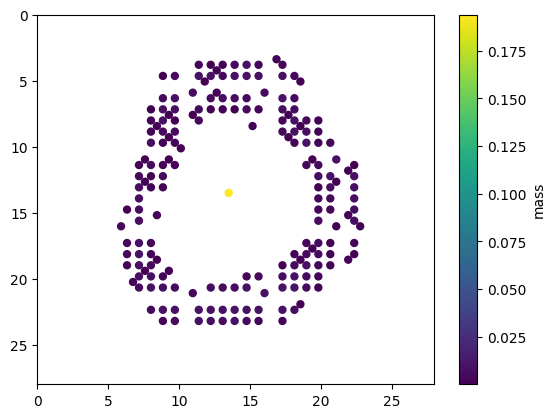

3.2183972874599185


In [43]:
newbc = {}
for key in barycenter:
   if barycenter[key] > .00002:
       newbc[key] = barycenter[key]
plotbarycenter(newbc, 100, zero_image_size)
print(cost)

In [7]:
from sklearn.preprocessing import normalize

In [11]:
cost = 0
barycenter = {}
id = 0
iddict = {}
dualweights = {}
numedges = 0
edgesdict = {}
adjacency_matrix = []
leafnodes = []
k = 20

apple_images = np.load("./testing images/apples.npy").astype('float64')
apple_images = normalize(apple_images, norm='l1')
apple_images = np.reshape(apple_images, (len(apple_images), 28, 28))
apple_image_points, apple_image_size = images_to_points(apple_images[:k])

cost = 0
barycenter = {}
doodle_sq_x, doodle_sq_y, doodle_sq_l = getboundingbox(apple_image_points)
doodle_qtree = quadtree(doodle_sq_x, doodle_sq_y, doodle_sq_l)
insert_list(doodle_qtree, apple_image_points)
doodle_qtree.killemptychildren()
id_nodes(doodle_qtree)
compute_barycenter(doodle_qtree, euclidean_dist, k)
compute_dual_weights(doodle_qtree, euclidean_dist, k)
construct_adjacency_matrix(doodle_qtree, k)
spread = math.sqrt(28**2+28**2)
barycenter = {}
mwu(doodle_qtree, euclidean_dist, .5, spread, k, numedges, apple_image_points,(doodle_sq_x, doodle_sq_y, doodle_sq_l))


115.9464193247292
{(6.328125, 3.796875): 1.794282808695643e-07, (6.328125, 4.640625): 1.7939933054798594e-07, (9.703125, 2.109375): 2.601854220289951e-07, (8.859375, 2.953125): 4.392980928727168e-07, (9.703125, 2.953125): 8.0297824274472e-07, (11.390625, 2.109375): 9.535050572788538e-07, (11.390625, 2.953125): 0.0011594234374635581, (12.234375, 2.109375): 1.3318368526479099e-06, (13.078125, 2.109375): 0.0006630081199947079, (12.234375, 2.953125): 0.004568354656847311, (13.078125, 2.953125): 0.004667105410192024, (7.171875, 3.796875): 5.07212495180043e-07, (8.015625, 3.796875): 3.7572645187474705e-07, (7.171875, 4.640625): 5.101473925445963e-07, (8.015625, 4.640625): 9.767859617614222e-07, (8.859375, 3.796875): 9.22114788060479e-07, (9.703125, 3.796875): 0.0012652592793532768, (8.859375, 4.640625): 0.0009496687486748993, (9.703125, 4.640625): 0.005240824764524005, (7.171875, 6.328125): 9.09292955752167e-07, (8.015625, 6.328125): 1.555575072742045e-06, (8.859375, 6.328125): 0.00131074503

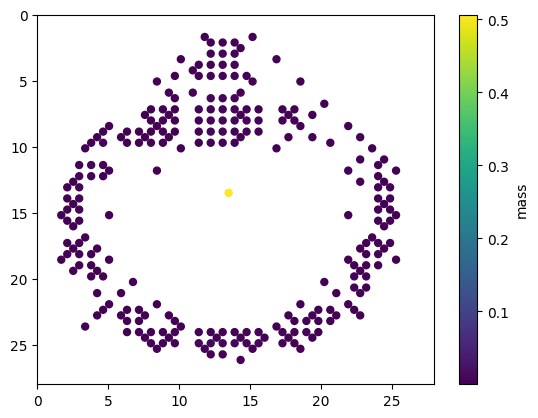

32.71286248938426


In [14]:
newbc = {}
for key in barycenter:
   if barycenter[key] > .00002:
       newbc[key] = barycenter[key]
plotbarycenter(newbc, 100, apple_image_size)
print(cost)